## Alzheimer Image Classification  

Given *images of 4 different classes*, let's try to classifify the **alzheimer** present in a given MRI.

We will use a TensorFlow/Keras pretrained MobileNetV2 CNN to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Creating File DataFrame

In [2]:
train_df = pd.read_csv("alzheimer_train_valid.csv")
test_df = pd.read_csv("alzheimer_benchamrk.csv")

In [3]:
test_df

,image_path,class
0,Benchmark\Non_Demented\non_871.jpg,Non_Demented
1,Benchmark\Non_Demented\non_3104.jpg,Non_Demented
2,Benchmark\Very_Mild_Demented\augmented_80_very...,Very_Mild_Demented
3,Benchmark\Very_Mild_Demented\augmented_123_ver...,Very_Mild_Demented
4,Benchmark\Moderate_Demented\augmented_182_mode...,Moderate_Demented
...,...,...
595,Benchmark\Mild_Demented\mild_46.jpg,Mild_Demented
596,Benchmark\Mild_Demented\mild_748.jpg,Mild_Demented
597,Benchmark\Mild_Demented\augmented_32_mild_319.jpg,Mild_Demented
598,Benchmark\Moderate_Demented\augmented_240_mode...,Moderate_Demented


# Creating Generators

In [4]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [5]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=4,
    seed=42,
    shuffle=False
)

Found 10176 validated image filenames belonging to 4 classes.
Found 2543 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.


# Modeling

In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [7]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

# Training

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=30,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=10,
                                                                restore_best_weights=True)])

                                                                

Epoch 1/30
2544/2544 [==============================] - 243s 95ms/step - loss: 1.0030 - accuracy: 0.5132 - val_loss: 0.9483 - val_accuracy: 0.5509
Epoch 2/30
2544/2544 [==============================] - 152s 60ms/step - loss: 0.8438 - accuracy: 0.6075 - val_loss: 0.8188 - val_accuracy: 0.6186
Epoch 3/30
2544/2544 [==============================] - 207s 81ms/step - loss: 0.7676 - accuracy: 0.6477 - val_loss: 0.8211 - val_accuracy: 0.6237
Epoch 4/30
2544/2544 [==============================] - 132s 52ms/step - loss: 0.7181 - accuracy: 0.6736 - val_loss: 0.8253 - val_accuracy: 0.6300
Epoch 5/30
2544/2544 [==============================] - 134s 53ms/step - loss: 0.6740 - accuracy: 0.6961 - val_loss: 0.7772 - val_accuracy: 0.6481
Epoch 6/30
2544/2544 [==============================] - 146s 57ms/step - loss: 0.6528 - accuracy: 0.6981 - val_loss: 0.7338 - val_accuracy: 0.6701
Epoch 7/30
2544/2544 [==============================] - 136s 54ms/step - loss: 0.6208 - accuracy: 0.7152 - val_loss: 0

In [9]:
confidence = model.predict(test_images)

150/150 [==============================] - 7s 43ms/step


In [10]:
ss = pd.DataFrame(confidence, columns = test_images.class_indices)

In [11]:
confidence = model.predict(test_images)
ss['predict'] = np.argmax(model.predict(test_images), axis=1)

150/150 [==============================] - 6s 42ms/step


In [12]:
ss

,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented,predict
0,2.060850e-03,2.700467e-13,6.108055e-01,3.871337e-01,2
1,1.803910e-09,6.828954e-17,9.999918e-01,8.265492e-06,2
2,5.053591e-01,6.407197e-04,3.799102e-06,4.939963e-01,0
3,6.744630e-01,2.117604e-04,1.022251e-05,3.253149e-01,0
4,1.733400e-01,1.166641e-02,1.194299e-01,6.955637e-01,3
...,...,...,...,...,...
595,2.890883e-02,8.019552e-07,9.467610e-01,2.432940e-02,2
596,8.534163e-01,2.508218e-13,1.393231e-01,7.260644e-03,0
597,7.805163e-02,9.218485e-01,6.802451e-11,9.989702e-05,1
598,3.417591e-03,9.965824e-01,4.324908e-17,4.541470e-11,1


In [13]:
reverse_mapping_dict = {v: k for k, v in test_images.class_indices.items()}
ss['predict'] = ss['predict'].map(reverse_mapping_dict)

In [14]:
ss

,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented,predict
0,2.060850e-03,2.700467e-13,6.108055e-01,3.871337e-01,Non_Demented
1,1.803910e-09,6.828954e-17,9.999918e-01,8.265492e-06,Non_Demented
2,5.053591e-01,6.407197e-04,3.799102e-06,4.939963e-01,Mild_Demented
3,6.744630e-01,2.117604e-04,1.022251e-05,3.253149e-01,Mild_Demented
4,1.733400e-01,1.166641e-02,1.194299e-01,6.955637e-01,Very_Mild_Demented
...,...,...,...,...,...
595,2.890883e-02,8.019552e-07,9.467610e-01,2.432940e-02,Non_Demented
596,8.534163e-01,2.508218e-13,1.393231e-01,7.260644e-03,Mild_Demented
597,7.805163e-02,9.218485e-01,6.802451e-11,9.989702e-05,Moderate_Demented
598,3.417591e-03,9.965824e-01,4.324908e-17,4.541470e-11,Moderate_Demented


# Results

In [15]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 73.50%


In [16]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

150/150 [==============================] - 6s 42ms/step


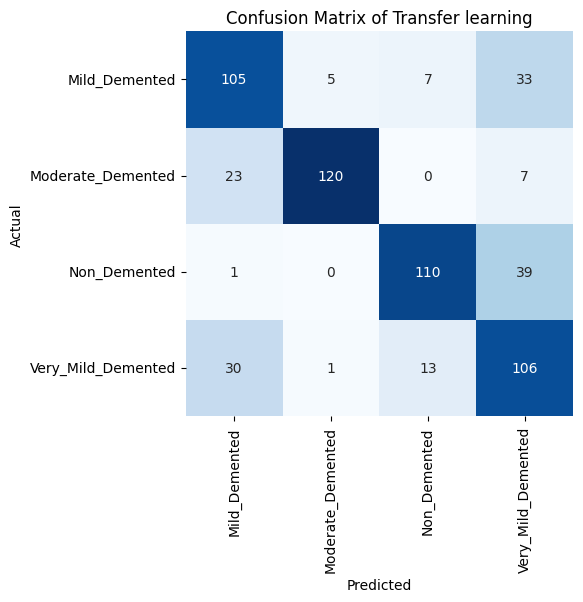

In [17]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Transfer learning")
plt.show()

In [18]:
print("TF Classification Report:\n----------------------\n", clr)

TF Classification Report:
----------------------
                     precision    recall  f1-score   support

     Mild_Demented       0.66      0.70      0.68       150
 Moderate_Demented       0.95      0.80      0.87       150
      Non_Demented       0.85      0.73      0.79       150
Very_Mild_Demented       0.57      0.71      0.63       150

          accuracy                           0.73       600
         macro avg       0.76      0.73      0.74       600
      weighted avg       0.76      0.73      0.74       600



----------------------------

In [19]:
tf_alzheimer_results = pd.concat([test_df, ss], axis = 1)[['image_path', 'class', 'predict', 
                                                            'Mild_Demented', 'Moderate_Demented',
                                                            'Non_Demented', 'Very_Mild_Demented']]

In [20]:
tf_alzheimer_results.to_csv('results_confidence/tf_results_confidence.csv', index = False)